In [13]:
%matplotlib inline
from scrape_scholar import *
import sqlite3 
import pandas as pd
import numpy as np
import networkx as nx
import altair as alt
import nx_altair as nxa
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pylab
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Função que realiza o scrap e salva os dados

In [14]:
def scrape_and_store(author_name):

    conn = sqlite3.connect("db.db")
    cur = conn.cursor()
    
    # Coletando os dados
    data = scrape(author_name)

    # Inserindo nas tables paper e author
    for paper in range(len(data)):
        conn.execute("INSERT OR IGNORE INTO paper (paper) VALUES (?)", [data[paper].get("title")])
        for author in data[paper].get("authors"):
            conn.execute("INSERT OR IGNORE INTO author (author) VALUES (?)", [author])
            
    conn.commit()
    
    aux_paper = pd.read_sql("SELECT * from paper", conn)
    aux_paper.columns = ['paper_id', 'paper']
    
    aux_author = pd.read_sql("SELECT * from author", conn)
    aux_author.columns = ['author_id', 'author']
           
    author_paper = pd.DataFrame(columns = ["paper", "author"])
    for paper in range(len(data)):
        for author in data[paper].get("authors"):
            author_paper = author_paper.append({"paper" : data[paper].get("title"), "author" : author}, ignore_index = True)  
     
    try:    
        author_paper_old = pd.read_sql("SELECT author, paper FROM author_paper", conn)
        author_paper = pd.merge(author_paper_old, author_paper, how = "outer")

    except:
        pass 
        
    author_paper = pd.merge(pd.merge(author_paper, aux_author), aux_paper)
    author_paper.to_sql("author_paper", con = conn, if_exists = "replace")

    conn.close()

## Iniciando o db

In [15]:
conn = sqlite3.connect("db.db")
cur = conn.cursor()
 
cur.executescript('''
DROP TABLE IF EXISTS author;
DROP TABLE IF EXISTS paper;
DROP TABLE IF EXISTS author_paper;

CREATE TABLE author(
id INTEGER PRIMARY KEY NOT NULL,
author TEXT NOT NULL UNIQUE);
CREATE TABLE paper(
id INTEGER PRIMARY KEY NOT NULL,
paper VARCHAT NOT NULL UNIQUE);
''')

conn.commit()
conn.close()

## Coletando dados de um autor

In [16]:
scrape_and_store("Jayme Luiz Szwarcfiter")

## Plotando autores

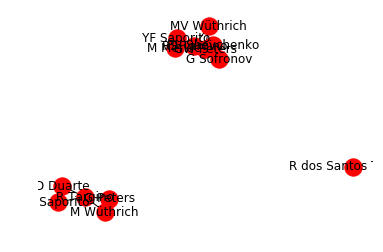

In [11]:
conn = sqlite3.connect("db.db")
cur = conn.cursor()
inpt = pd.read_sql("SELECT * FROM author_paper", conn)
conn.close()

inpt = inpt[["paper", "author"]]
inpt["values"] = 1

lst = list(inpt["author"])
names = sorted(list(set(lst)))

inpt = inpt.pivot_table(index = "paper", columns = "author").fillna(0)
inpt.index.name = None

cols = inpt.columns
X = sp.csr_matrix(inpt.astype(int).values)
Xc = X.T * X  
Xc.setdiag(0)  

inpt = pd.DataFrame(Xc.todense(), index = cols, columns = cols)
graph = nx.from_numpy_matrix(inpt.values.astype(int))

graph = nx.relabel_nodes(graph, dict(enumerate(names)))
pos = nx.spring_layout(graph)

cont = 0
for n in graph.nodes():
    graph.nodes[n]["author"] = names[cont]
    cont += 1

#nxa.draw_networkx(G = graph, pos = pos, node_tooltip = ["author"]).interactive()

nx.draw_networkx(G = graph, pos = pos)
limits = plt.axis('off')

## Plotando papers

In [18]:
conn = sqlite3.connect("db.db")
cur = conn.cursor()
inpt = pd.read_sql("SELECT * FROM author_paper", conn)
conn.close()

inpt2 = inpt.copy()
inpt = inpt[["paper", "author"]]
inpt["values"] = 1

lst = list(inpt["paper"])
names = sorted(list(set(lst)))

inpt = inpt.pivot_table(index = "author", columns = "paper").fillna(0)
inpt.index.name = None

cols = inpt.columns
X = sp.csr_matrix(inpt.astype(int).values)
Xc = X.T * X  
Xc.setdiag(0)  

inpt = pd.DataFrame(Xc.todense(), index = cols, columns = cols)
graph = nx.from_numpy_matrix(inpt.values.astype(int))

graph = nx.relabel_nodes(graph, dict(enumerate(names)))
pos = nx.spring_layout(graph)

unique_papers = list(set(inpt2["paper"].values))
unique_papers.sort()

authors = []
for papers in unique_papers:
    authors.append(str(list(inpt2[inpt2['paper'] == papers]['author'].values)).replace("[", "").replace("]", "").replace("'", ""))
    
cont = 0
for n in graph.nodes():
    graph.nodes[n]["paper"] = names[cont]
    graph.nodes[n]["authors"] = authors[cont]
    cont += 1

nxa.draw_networkx(G = graph, pos = pos, node_tooltip = ["paper", "authors"]).interactive()

#nx.draw_networkx(G = graph, pos = pos)
#limits = plt.axis('off')

KeyboardInterrupt: 